This notebook contains the preparation of data (0), the modelling of the data (1), and visualisations of the results (2).

#### 0. Prepare the data

##### a) Load the daset that contains the UN GD speeches.

In [2]:
import os
import numpy as np
import pandas as pd

sessions = np.arange(25, 76)
data = []

for session in sessions:
    directory = "data/TXT/Session " + str(session) + " - " + str(1945 + session)
    for filename in os.listdir(directory):
        f = open(os.path.join(directory, filename))
        if filename[0] == ".": #ignore hidden files
            continue
        splt = filename.split("_")
        # Start from 1995
        if session < 50:
            continue
        data.append([session, 1945 + session, splt[0], f.read()])

df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])
df_speech.head() # Shape: (4913, 4)

,Session,Year,ISO-alpha3 Code,Speech
0,50,1995,BDI,The United Nations is celebrating its fiftieth...
1,50,1995,VNM,"Allow me at the outset, on behalf of the\ndele..."
2,50,1995,PAK,"I extend to you, Sir, my\ndelegation’s felicit..."
3,50,1995,MLI,We\nare meeting on the eve of the fiftieth ann...
4,50,1995,FRA,"Mr. President, I should like to say first how\..."


Also, load the most recent speeches. Source: https://gadebate.un.org/generaldebate76/en/

In [3]:
# Load recent speeches
from pdfminer.high_level import extract_text

folder = f'data/PDF/Session_76 - 2022/'
data = []

for file in os.listdir(folder):
    if file.startswith('.'):
        continue
    f = open(os.path.join(folder, file), "rb")
    splt = file.split("_")
    data.append([76, 2022, splt[0], extract_text(f)])

df_recent = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])

df_speech = pd.concat([df_speech, df_recent]) # Shape: (4923, 4)

Dataset now consists of 4923 rows and 4 columns.

##### b) Load the dataset containing the expenses

Downloaded from https://ec.europa.eu/eurostat/databrowser/view/GOV_10A_EXP__custom_3484912/default/table?lang=en

In [81]:
# Load COFOG
cofog = pd.read_csv("data/gov_10a_exp__custom_3484912_page_tabular.tsv", sep='\t')

cofog.iloc[:,0] = cofog.iloc[:,0].str.split(',').str[-1]
cofog.rename(columns={cofog.columns[0]: "ISO-alpha2 Code"}, inplace=True)

# Perform some preprocessing
cofog = cofog.melt(id_vars=["ISO-alpha2 Code"], var_name="Year", value_name='Expenses') # Transpose
cofog['Year'] = cofog['Year'].astype(int) # Typecasting
cofog.loc[:,'Expenses'] = cofog.loc[:,'Expenses'].replace('', np.isnan) # Replace EL with GR to align with ISO
cofog.loc[:,'Expenses'] = cofog.loc[:,'Expenses'].dropna()
cofog['Expenses'] = cofog['Expenses'].astype(str).str.strip().str.extract(r'(\d+.\d+)').astype('float')
cofog.loc[:,'ISO-alpha2 Code'] = cofog.loc[:,'ISO-alpha2 Code'].replace('EL', 'GR') # Replace EL with GR to align with ISO

cofog.head() #Shape (832, 3)


,ISO-alpha2 Code,Year,Expenses
0,AT,1995,55.8
1,BE,1995,52.6
2,BG,1995,31.7
3,CH,1995,33.3
4,CY,1995,30.9


COFOG contains ISO-alpha2 Code while `df_speeches` has ISO-alpha3 codes. We can use the provided `UNSD Methodology` that contains both of these.

##### c) Load dataset containing all names of countries and codes

In [82]:
df_codes = pd.read_csv("data/UNSD — Methodology.csv", delimiter=';')

df_un_merged = cofog.merge(df_codes, how='inner') # DF goes from 832 -> 780, some codes not align
df_un_merged = df_un_merged[["ISO-alpha3 Code", "ISO-alpha2 Code", "Expenses", "Country or Area", "Year", "Region Name", "Sub-region Name"]]

df_un_merged.head() # Schape (780, 7)

,ISO-alpha3 Code,ISO-alpha2 Code,Expenses,Country or Area,Year,Region Name,Sub-region Name
0,AUT,AT,55.8,Austria,1995,Europe,Western Europe
1,AUT,AT,55.6,Austria,1996,Europe,Western Europe
2,AUT,AT,52.3,Austria,1997,Europe,Western Europe
3,AUT,AT,52.2,Austria,1998,Europe,Western Europe
4,AUT,AT,52.1,Austria,1999,Europe,Western Europe


Dataset contains 780 rows and 7 features.

##### e) Merge datasets
Now we have a COFOG dataframe and a speeches which can be merged with the corresponding `ISO-alpha3` codes and the specific year. We also remove non-European countries.

In [83]:
df_final = df_speech.merge(df_un_merged, how='inner', on=['Year', 'ISO-alpha3 Code'])
df_final.head()

,Session,Year,ISO-alpha3 Code,Speech,ISO-alpha2 Code,Expenses,Country or Area,Region Name,Sub-region Name
0,50,1995,FRA,"Mr. President, I should like to say first how\...",FR,54.8,France,Europe,Western Europe
1,50,1995,IRL,I warmly congratulate the\nPresident on his el...,IE,40.4,Ireland,Europe,Northern Europe
2,50,1995,BEL,“[Today more then ever we should realize that\...,BE,52.6,Belgium,Europe,Western Europe
3,50,1995,ISL,"Mr. President, may I\ncongratulate you on your...",IS,NaN,Iceland,Europe,Northern Europe
4,50,1995,HUN,"May I extend our\ncongratulations to you, Sir,...",HU,55.2,Hungary,Europe,Eastern Europe


##### f) Clean the `Speech` column

In the cleaning, the speeches are tokenized and stopwords and interpunction are removed.

In [84]:
# Copy speech to new column 'Text"
df_final['Text'] = df_final.loc[:,'Speech'].copy()

In [85]:
from nltk import word_tokenize
from nltk.corpus import stopwords

def preprocess(words):
    """
    Input: List of (tokenized) words
    Return: List of (tokenized) words without stopwords and interpunction
    """
    sw = stopwords.words("english")
    clean = []
    for w in words:
        w = str.lower(w)
        if (w.isalpha()) and (w not in sw):
            clean.append(w)

    return clean

# ! Warning, cell takes longer: about 40 seconds
df_final.loc[:,'Text'] = df_final.loc[:,'Text'].apply(word_tokenize)
df_final.loc[:,'Text'] = df_final.loc[:,'Text'].apply(preprocess)

df_final['Text'].values[4][0:10]

['may',
 'extend',
 'congratulations',
 'sir',
 'upon',
 'election',
 'president',
 'general',
 'assembly',
 'historic']

##### h) Quantify the 'attention for the topic of climate change' by the Member States.

Approach: 
1. We use a labeled dataset which is based on this paper
https://arxiv.org/abs/2012.00614.downloaded and is downloaded from https://www.sustainablefinance.uzh.ch/en/research/climate-fever.html.
2. We will drop the claims that didn't have enough evidence.  
3. We collect the words from the `evidence_id` (which is in the `evidences` column): example: ['carbon', 'dioxide']
4. We clean the list: make lowercase, tokenize, remove interpunction.
5. We manually create a list to remove a small set of words that are not climate related and skew the results.
6. We compare the list climate-related words to the words in the speeches and count the occurences.

In [86]:
# 1. Loading the labeled dataset
climate = pd.read_json('data/climate-fever-dataset-r1.jsonl', lines=True) 

# 2. Retrieve the values and remove the uncertain/disputed ones
climate = climate[(climate.claim_label != 'DISPUTED') & (climate.claim_label != 'NOT_ENOUGH_INFO')]

climate.head()

,claim_id,claim,claim_label,evidences
0,0,Global warming is driving polar bears toward e...,SUPPORTS,[{'evidence_id': 'Extinction risk from global ...
1,5,The sun has gone into ‘lockdown’ which could c...,SUPPORTS,"[{'evidence_id': 'Famine:386', 'evidence_label..."
2,6,The polar bear population has been growing.,REFUTES,"[{'evidence_id': 'Polar bear:1332', 'evidence_..."
3,9,Ironic' study finds more CO2 has slightly cool...,REFUTES,"[{'evidence_id': 'Atmosphere of Mars:131', 'ev..."
4,10,Human additions of CO2 are in the margin of er...,REFUTES,[{'evidence_id': 'Carbon dioxide in Earth's at...


In [87]:
# 3. Extract evidences/evidence 
evidences = [i for i in climate.evidences.values]

res = []
for i in evidences:
    evi = dict(i[0])
    for key, value in evi.items():
        if key == 'evidence_id':
            res.append(value.split(':')[0])

res = ' '.join([i for i in set(res)])

In [88]:
# 4. Extract evidences and clean
climate_words = word_tokenize(res)
climate_words = preprocess(climate_words)

frequent_words = ['election', 'general', 'united', 'nations', 'france', 'election','european', 'state', 'government', 'agreement', 'great', 'el', 'since']

climate_words = [word for word in climate_words if word not in frequent_words]

print(len(climate_words)) # 655 climate related words

655


5. Count the occurences of climate related words in the speeches 

In [89]:
def count_occurrences(words):
    counts = {}
    count = 0
    for word in climate_words:
        if (word in words):
            if word in counts.keys():
                counts[word] += 1
            else:
                counts[word] = 1
    total = sum(counts.values())
    return total

# Warning, cell takes long: over 1m
df_final['Count'] = df_final['Text'].apply(count_occurrences)

In [90]:
df_final['Count'][:10].values

array([135, 157,  92, 159,  90, 117, 122, 119,  77,  90])

In [91]:
df_final.columns

Index(['Session', 'Year', 'ISO-alpha3 Code', 'Speech', 'ISO-alpha2 Code',
       'Expenses', 'Country or Area', 'Region Name', 'Sub-region Name', 'Text',
       'Count'],
      dtype='object')

##### h) Exploration phase

In [92]:
wc_years = np.mean(df_final.Count.values) # Mean word count over the years
max_years = np.max(df_final.Count.values) # Max word count over the years
min_years = np.min(df_final.Count.values) # Max word count over the years

print(f"Mean climate related word count between 1995 and 2022: \t {wc_years}")
print(f"Highest climate related word count between 1995 and 2022: \t {max_years}")
print(f"Lowest climate related word count between 1995 and 2022: \t {min_years}")

Mean climate related word count between 1995 and 2022: 	 101.32253886010362
Highest climate related word count between 1995 and 2022: 	 205
Lowest climate related word count between 1995 and 2022: 	 17


In [94]:
GDP_years = np.mean(df_final.Expenses.values) # Mean GDP over the years
max_GDP = np.max(df_final.Expenses.values) # Highest GDP % to environmental protection over the years
min_GDP = np.min(df_final.Expenses.values) # Lowest GDP % to environmental protection over the years

print(GDP_years)
print(max_GDP)
print(min_GDP)

nan
nan
nan


In [61]:
# Might come in handy
df_final['Decade'] = df_final['Year'].apply(lambda i: round(i, -1))

- All EU countries expenses and climate change related word count mean, grouped by year

In [97]:
grouped = df_final.groupby(['Year'], as_index=False, sort=False)[['Expenses', 'Count']].sum()
grouped.head()

,Year,Expenses,Count
0,1995,1326.9,2617
1,1996,1297.2,2569
2,1997,1269.9,2691
3,1998,1299.3,2721
4,1999,1309.0,2449


In [105]:
print(grouped[grouped['Count'] == min(grouped['Count'])])
print(grouped[grouped['Count'] == max(grouped['Count'])])
print(np.mean(grouped['Count']))

   Year  Expenses  Count
7  2002    1320.0   2049
    Year  Expenses  Count
24  2019    1287.6   4143
3008.5


In [104]:
print(grouped[grouped['Expenses'] == min(grouped['Expenses'])])
print(grouped[grouped['Expenses'] == max(grouped['Expenses'])])
print(np.mean(grouped['Expenses']))

    Year  Expenses  Count
12  2007    1264.9   3631
    Year  Expenses  Count
25  2020    1436.0   3536
1327.296153846154


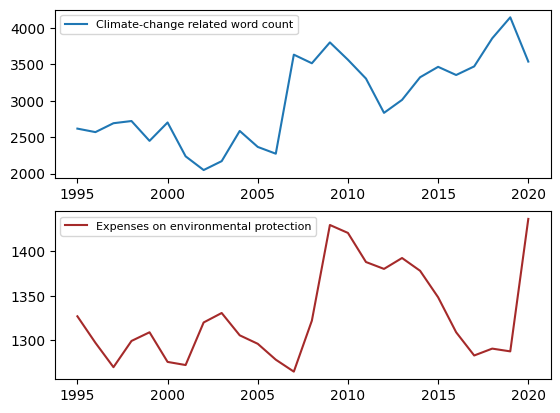

In [117]:
import matplotlib.pyplot as plt

X = grouped['Year'].values
y1 = grouped['Count'].values
y2 = grouped['Expenses'].values

fig, ax = plt.subplots(2)

ax[0].plot(X, y1, label="Climate-change related word count")
ax[1].plot(X, y2, label="Expenses on environmental protection", color='brown')

ax[0].legend(loc=2, prop={'size': 8})
ax[1].legend(loc=2, prop={'size': 8})
plt.show()

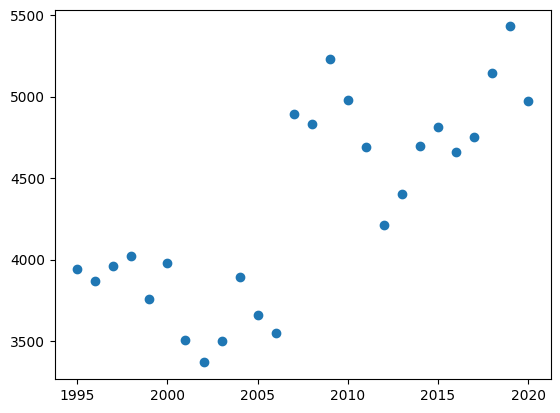

In [113]:
plt.scatter(X, (y1+y2))

Scatter plot suggests a linear relation between counts and expenses

From here some extra exploration

- EU countries grouped by region and interested in expenses and climate change related word count mean

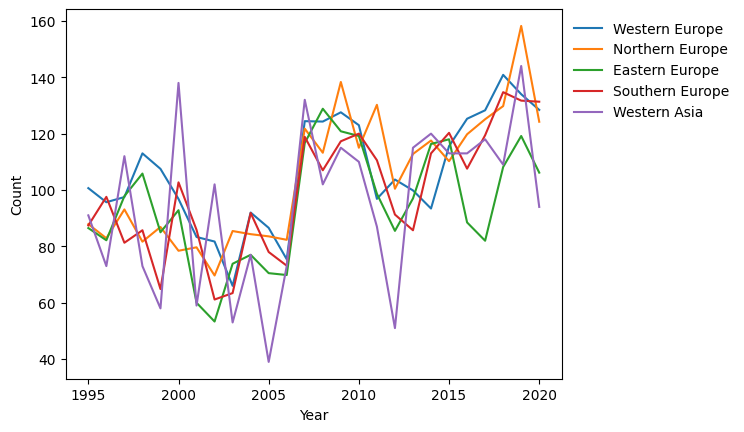

In [68]:
import seaborn as sns

# Climate related word count for regions (in EU)
df = df_final.groupby(['Year', 'Sub-region Name'], as_index=False, sort=False)[['Expenses','Count']].mean()

ax = sns.lineplot(x="Year", y="Count", hue='Sub-region Name', data=df, palette='tab10')
ax.legend(ncol=1, bbox_to_anchor=(1, 1), frameon=False)

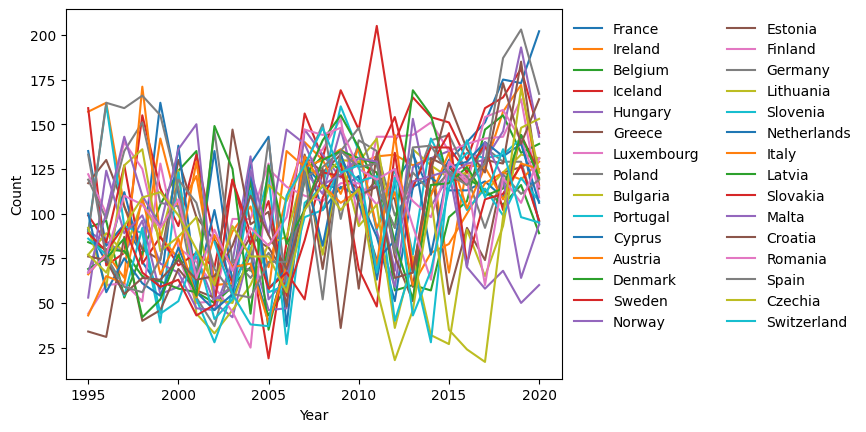

In [82]:
# Climate related word count for countries (in EU)
ax = sns.lineplot(x="Year", y="Count", hue='Country or Area', data=df_final, palette='tab10')
ax.legend(ncol=2, bbox_to_anchor=(1, 1), frameon=False)

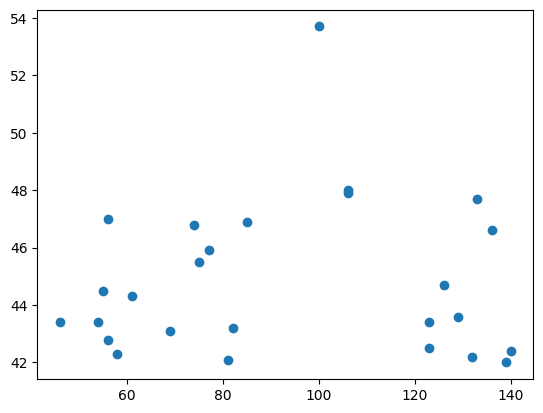

In [86]:
df_west = df_final[df_final['Country or Area'] == 'Netherlands']

X = df_west['Count']
y = df_west['Expenses']

plt.scatter(X, y)

#### 1. Modelling

In [213]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

X = preprocessing.scale(grouped['Count'].values) # Standardizing X
y = preprocessing.scale(grouped['Expenses'].values) # and Y

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [219]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

lm_model = make_pipeline (
    LinearRegression(fit_intercept=True)
)

lm_model.fit(X_train[:, np.newaxis], y_train)

xfit = np.linspace(min(X), max(X), 9)
pred_y = lm_model.predict(xfit[:, np.newaxis])

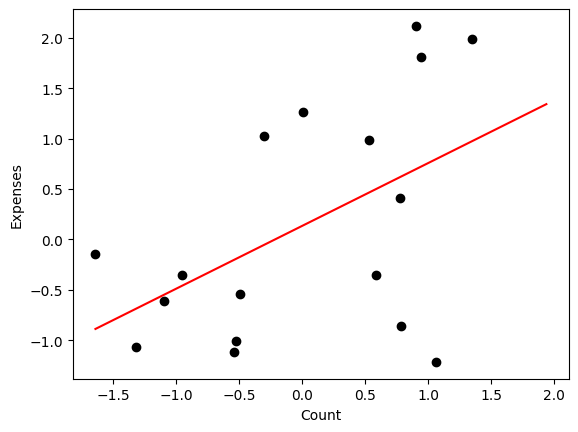

In [220]:
fig, ax = plt.subplots(1)

ax.scatter(X_train, y_train, c='black')
ax.set_xlabel("Count")
ax.set_ylabel("Expenses")

ax.plot(xfit, pred_y, c='red');
plt.show()


In [221]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model
# The mean squared error
print("Mean squared error - Test: %.2f" % mean_squared_error(y_test, pred_y))
# Explained variance score: 1 is perfect prediction
print('Variance score - Test: %.2f' % r2_score(y_test, pred_y))

Mean squared error - Test: 1.63
Variance score - Test: -3.40


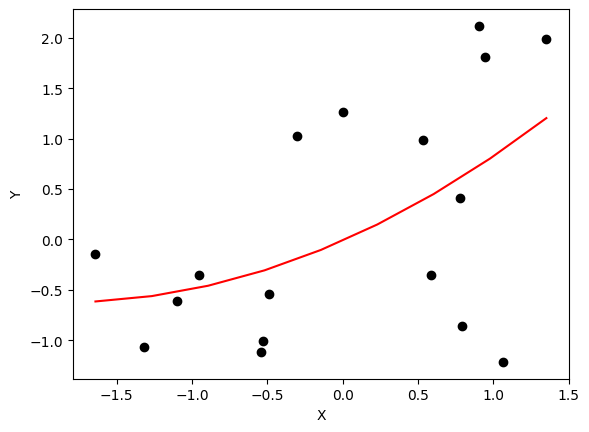

In [222]:
from sklearn.preprocessing import PolynomialFeatures

X_train, X_test, y_train, y_test = train_test_split(X, y, \
    test_size=0.33, random_state=42)

polymodel = make_pipeline(PolynomialFeatures(2), LinearRegression(fit_intercept=True))

polymodel.fit(X_train[:, np.newaxis], y_train)

xfit = np.linspace(min(X_train), max(X_train), 9)

y_pred = polymodel.predict(xfit[:, np.newaxis])

fig, ax = plt.subplots()
ax.scatter(X_train, y_train, c='black')

ax.set_xlabel("X")
ax.set_ylabel("Y")

ax.plot(xfit, y_pred, c='red');
plt.show()

In [223]:
# The mean squared error
print("Mean squared error - Test: %.2f" % mean_squared_error(y_test, y_pred))
# Explained variance score: 1 is perfect prediction
print('Variance score - Test: %.2f' % r2_score(y_test, y_pred))


Mean squared error - Test: 1.21
Variance score - Test: -2.25


#### 2. Visualisation of the results

Remember the principles of data visualisation: 
1. Know the audience: Curse of expertise, informative labels.
2. One plot, one message.
3. Adapt figure to medium: Thicker lines, less information for smaller mediums.
4. Caption! 
5. Do not trust the defaults (especially in Matplotlib)
6. Use color effectively. Color maps: sequential vs diverging vs qualitative.

    *Diverging* = if there’s a meaningful middle point
    
    *Sequential* = for a more intuitive reading
7. Avoid chartjunk = unnecessary visual elements
8. Do not mislead audience
9. Chose message over beauty
10. Know and use the right tool: matplotlib, seaborn, geopandas, networkX.


In [224]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set styling parameters for sns
sns.set_theme(); sns.set_context('notebook'); sns.set_style('ticks')

Linegraph

In [227]:
#TODO Plot lingraph: X = Year, Y = Expenses, Lines = Different countries?
# ax = sns.lineplot(x="Year", y="Count", hue='Sub-region Name', data=grouped, palette='tab10')
# ax.legend(ncol=2, bbox_to_anchor=(1, 1), frameon=False)

SyntaxError: unterminated string literal (detected at line 2) (1300345266.py, line 2)

Scatterplot

In [ ]:
# Scatterplot: X = Year, Y = Expenses, Dot = Country
# df_west = df_speech[df_speech['Sub-region Name'] == 'Western Europe']
# ax = sns.scatterplot(x="Count", y="Expenses", hue='Country or Area', data=df_west)
# ax.legend(ncol=2, frameon=False)

Histogram

In [ ]:
#TODO Plot histogram: group data by ISO....

Geopandas

In [ ]:
# import geopandas

# world = geopandas.read_file(geopandas.datasets.get_path("naturalearth_lowres"))
# europe = world.merge(df_speech, how='inner', left_on='name', right_on='Country or Area')

In [ ]:
# ax = world.plot(, color='white', edgecolor='black')
# fig, ax = plt.subplots(1)
# europe.plot(column='Count', ax=ax, legend=True)